# <p style="padding:10px;background-color:#9619EC;margin:0;color:#FFFFFF;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Uber&Lyft Price Prediction</p>

<p style="text-align:center; ">
<img src="https://arc-anglerfish-arc2-prod-gmg.s3.amazonaws.com/public/LQMSPWQ3VJG7LHDHQQKDNYQWOY.jpg" style='width: 650px; height: 350px;'>
</p>

# **Предсказание ценника для поездки в аггрегаторе такси Uber и Lyft.**



<a id="1"></a>
# <p style="padding:10px;background-color:#9619EC;margin:0;color:#FFFFFF;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Импорт библиотек для проекта</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import make_union, make_pipeline
import holidays
pd.set_option('display.precision', 2)

# **Базовый EDA и знакомство с датасетом.**

In [3]:
# импорт датасета и первая оценка
data = pd.read_csv("./data/uber_lyft_price_prediction.csv")
# from google.colab import files
# data = pd.read_csv('uber_lyft_price_prediction.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

In [4]:
# проверяем и удалаем строки с пропущенными значениями
def check_missing(dataset, output_path=None):
    result = pd.concat([dataset.isnull().sum(), dataset.isnull().mean()], axis=1)
    result = result.rename(index=str, columns={0: 'total_missing', 1: 'proportion'})
    if output_path:
        result.to_csv(output_path+"missing_data.csv")
        print(output_path, 'missing_data.csv')
    return result

In [5]:
check_missing(dataset=data)

,total_missing,proportion
id,0,0.00
timestamp,0,0.00
hour,0,0.00
day,0,0.00
month,0,0.00
datetime,0,0.00
timezone,0,0.00
source,0,0.00
destination,0,0.00
cab_type,0,0.00


In [6]:
def drop_missing(dataset, axis=0):
    data_copy = dataset.copy(deep=True)
    data_copy = data_copy.dropna(axis=axis, inplace=False)
    return data_copy

In [8]:
data = drop_missing(dataset=data)

In [9]:
# удаляем столбец id
data.drop(columns=['id'],axis= 1, inplace= True)

In [ ]:
# оцениваем распределение числовых данных
data.hist(figsize=(18, 10))

# **Dataset summary**

 При оценке нашего датасета мы:
 1. Рассмотрели данные, которые составили 693071 наблюдение, однако именно по нашей целевой переменной мы имели около 8% пропусков. Для дальнейшей работы мы удалили данные наблюдения (при глубокой оценке они включали в себя незначительные (около 100 метров) расстояния поездок или иные аномалии).
 2. Были выявлены признаки, одинаковые для всех наблюдений (timezone), а также признаки,не оказывающие влияния на наши данные (id).
 3. В датасете отражены признаки дублирующие друг друга: datetime  и day+month+hour; source  и   destination  отражают distance; name, icon и product_id фактически описывают класс автомобиля, выехавшего на вызов; short_summary и long_summary лписывают погодные условия.
 4. Ни один числовой признак не имеет нормального распределения.

# **Data processing с обоснованием значимости числовых колонок и их удаления.**

<ipython-input-43-d3456ebf9f9d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data.corr()[['price']].sort_values(by='price', ascending=False)


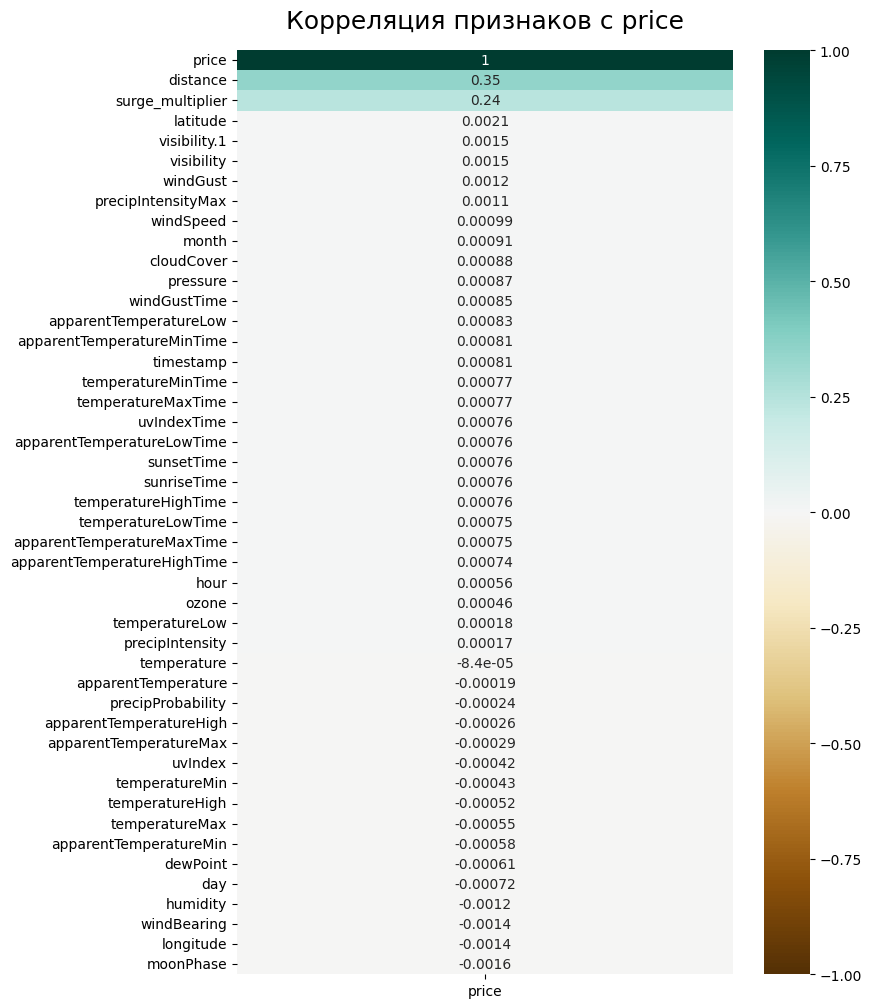

In [ ]:
#Корреляция по Оценке счастья
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['price']].sort_values(by='price', ascending=False)
, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляция признаков с price', fontdict={'fontsize':18}, pad=16);

# **Дисперсионный анализ**
Мы будем применять метод ANOVA для поиска признаков наиболее важных (интересных, насыщенных информацией) для обучения модели.

In [ ]:
# Определим в датасете лишние признаки методом ANOVA (дисперсионный анализ)
from sklearn.feature_selection import f_regression
data = data.drop(['datetime'], axis=1).dropna()
pd.set_option('display.float_format', '{:.2f}'.format)
col_names = df.drop(['price'], axis = 1).select_dtypes(include=[np.number]).columns
x = data.drop(['price'], axis = 1).select_dtypes(include=[np.number])
y = data['price'].values
column_names = col_names
[f_stat, f_p_value] = f_regression(x,y)
column_names = x.columns
f_test_df = pd.DataFrame({'Feature':  x.columns,
                          'F_stat': f_stat,
                          'P_value': f_p_value
                          })
f_test_df.sort_values('P_value')

,Feature,F_stat,P_value
4,distance,86228.75,0.00
5,surge_multiplier,39151.47,0.00
6,latitude,2.78,0.10
34,moonPhase,1.64,0.20
30,visibility.1,1.43,0.23
16,visibility,1.43,0.23
7,longitude,1.28,0.26
27,windBearing,1.22,0.27
12,humidity,0.98,0.32
14,windGust,0.95,0.33


# **Обоснование значимости категориальных колонок и их удаления.**

In [ ]:
cat_cols = ['hour', 'destination','short_summary','source', 'cab_type','name']

def chi_sq_test(ct):
    # input crosstab of 2 categorical variables
    stat, p, dof, expected = chi2_contingency(ct)

    # interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Both variables are Dependent (reject H0)')
    else:
        print('Both variables are Independent (H0 holds true)')

def cat_col_test(df, cat_colname, target_colname):

    print(f"Column name - {cat_colname}")
    ct = pd.crosstab(df[cat_colname],df[target_colname])
    chi_sq_test(ct)

for c in cat_cols:
    cat_col_test(data, c, 'price')

Column name - hour
p value is 0.3568087232252539
Both variables are Independent (H0 holds true)
Column name - destination
p value is 0.0
Both variables are Dependent (reject H0)
Column name - short_summary
p value is 0.40058834184797343
Both variables are Independent (H0 holds true)
Column name - source
p value is 0.0
Both variables are Dependent (reject H0)
Column name - cab_type
p value is 0.0
Both variables are Dependent (reject H0)
Column name - name
p value is 0.0
Both variables are Dependent (reject H0)


In [ ]:
# Функция по предварительной очистки датасета. Работа с дублирующимися признаками и нечисловыми.
def for_prepare(data):
    data = data.loc[:, ['hour', 'distance', 'datetime','surge_multiplier','short_summary','source', 'destination', 'cab_type','name', 'price']]
    data['datetime'] = pd.to_datetime(data['datetime'])
    holiday_dates = holidays.US(years=2018, state='NY').keys() #ориентируясь на регион определяем значимые часы и часы-пик для влияния на цену
    data['is_holiday'] = data['datetime'].dt.date.isin(holiday_dates).astype(int)
    data['is_weekend'] = data['datetime'].dt.weekday.isin([5, 6]).astype(int)
    data = data.drop(['datetime'], axis=1).dropna()
    data = data.drop_duplicates(subset=['hour', 'destination', 'distance', 'price']) #удаляем дублирующие значения для сжатия датасета и дальнейшей реализации пайплайна
    return data

df = for_prepare(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284271 entries, 0 to 693070
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   hour              284271 non-null  int64  
 1   distance          284271 non-null  float64
 2   surge_multiplier  284271 non-null  float64
 3   short_summary     284271 non-null  object 
 4   source            284271 non-null  object 
 5   destination       284271 non-null  object 
 6   cab_type          284271 non-null  object 
 7   name              284271 non-null  object 
 8   price             284271 non-null  float64
 9   is_holiday        284271 non-null  int64  
 10  is_weekend        284271 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 26.0+ MB


In [ ]:
y = df['price']
x = df.drop(['price'],axis=1)

In [ ]:

def get_onehot_col(df):
    return df[['short_summary','source', 'cab_type','name','is_holiday','is_weekend']] # признаки 'hour', 'destination' не были включены после оценки работы модели с их использованием

def get_scaler_cols(df):
    return df[['distance', 'surge_multiplier']]

my_prepare = make_union(*[
    make_pipeline(FunctionTransformer(get_onehot_col, validate=False),  OneHotEncoder(sparse_output=False)),
    make_pipeline(FunctionTransformer(get_scaler_cols, validate=False), StandardScaler())
    ])


x = my_prepare.fit_transform(x)
print(print(x.shape))
y = df['price']
print(print(y.shape))

(284271, 40)
None
(284271,)
None


# **Dimentionality reduction**

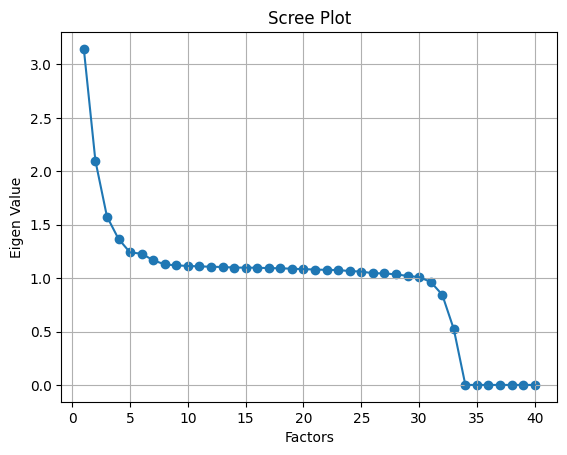

In [ ]:
#Рассчет собсвтенных чисел (PCA)
from sklearn.decomposition import PCA
scaler = StandardScaler()
x = scaler.fit_transform(x)
ev, _ = np.linalg.eig(np.cov(x.T))
ev = np.sort(ev)[::-1]
plt.scatter(range(1,x.shape[1]+1),ev)
plt.plot(range(1,x.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_.sum()

0.7550819774898749

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
x = principalComponents
y = df['price']


# Поэтапно поделим выборку на 3 части для обучения, настройки гиперпараметров и тестирования
X_trainval, X_test, y_trainval, y_test = train_test_split(x,y,test_size=0.2, random_state=12)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=12)
print("Размер выборки training: {}, размер выборки для настройки параметров: {}, размер выборки для тестирования:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Размер выборки training: 170562, размер выборки для настройки параметров: 56854, размер выборки для тестирования: 56855



# **Regression. Testing**

In [ ]:
# Обучаем ExtraTreesR на данных после факторного анализа
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
model_FA_ExraTR = ExtraTreesRegressor()
model_FA_ExraTR.fit(X_train, y_train)

# сделаем прогноз
y_pred = model_FA_ExraTR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score", r2_score)
# r2_score 0.9418459666063844

Mean Squared Error: 5.29823039700656
Mean Absolute Error: 1.4806763281654578
r2_score 0.9509040609150119


# **Summary.**

В данной работе были проанализированы более 693000 наблюдений с целью создания модели, предсказывающей стоимость поездки. В результате анализа и обработки данных фактически значимыми оказались лишь 8 признаков из 55.
При работе наиболее информативной показала себя модель Extra Trees Regressor, ключевой параметр оценки R2 равен более 0,95, что свидетельствует о хорошей работе данной модели.